In [126]:
#  Importação das bibliotecas necessárias
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

In [127]:
# Abrindo o arquivo CSV como dataframe "df"
df = pd.read_csv("..\\data\\survey_results.csv")

In [128]:
# Escolha qual cliente você deseja fazer a predição
# O nome deve bater com o presente na coluna "organization" do csv
loja = "VRPA - O CORINGAO"

# Removendo tickets duplicados
df = df.sort_values(by=["ticket_id"]).drop_duplicates(subset=["ticket_id"], keep="last")

# Removendo a avaliação de tipo "2" caso exista no CSV
df = df[df["type"] != "2"]

# Filtrando de df apenas as linhas onde "organization" é igual a loja desejada para df_
df_ = df[df['organization'].str.contains(loja, na=False)]

# Transformando a coluna de data "createdDate" para o formato YYYY-MM
# Isso é necessário caso queira fazer uma predição por mês, Caso queira fazer uma predição
# por DIA, altere strftime('%Y-%m') para strftime('%Y-%m-%d)
df_['createdDate'] = pd.to_datetime(df['createdDate']).dt.strftime('%Y-%m') # ou %Y-%m-%d
df_


C:\Users\VR Belém - PDV\AppData\Local\Temp\ipykernel_8912\1427155278.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ticket_id,createdDate,status,category,resolvedInFirstCall,urgency,chatWaitingTime,chatTalkTime,serviceFirstLevel,serviceSecondLevel,serviceThirdLevel,lifeTimeWorkingTime,organization,analyst,createdBy,type,value,comment
5339,1254137,2022-10,Resolvido,Duvida,True,Baixa - COM correcao,3.0,1.0,Administracao de Preco,Administrativo / Cadastro / Estoque / Logistica,NaN,2.0,VRPA - O CORINGAO - L01 - (G599),Hugo Mesquita,Ricardo Martins,3,7,NaN
5340,1254154,2022-10,Resolvido,Duvida,True,Baixa - COM correcao,4.0,1.0,Administracao de Preco,Administrativo / Cadastro / Estoque / Logistica,NaN,4.0,VRPA - O CORINGAO - L01 - (G599),Hugo Mesquita,Rodrigo Oliveira,3,10,NaN
5341,1254159,2022-10,Resolvido,Duvida,True,Baixa - COM correcao,5.0,2.0,Administracao de Preco,Administrativo / Cadastro / Estoque / Logistica,NaN,3.0,VRPA - O CORINGAO - L01 - (G599),Hugo Mesquita,Denise Sales,S/A,S/N,NaN
5411,1256810,2022-10,Resolvido,Inatividade,True,Baixa - COM correcao,6.0,55.0,Inatividade,NaN,NaN,56.0,VRPA - O CORINGAO - L01 - (G599),Hugo Mesquita,Denise Sales,3,10,NaN
5431,1258034,2022-10,Resolvido,Desistencia,True,Baixa - COM correcao,5.0,1.0,Desistencia,NaN,NaN,1.0,VRPA - O CORINGAO - L01 - (G599),Rodolfo Joaquim,Dalva Chagas,3,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28895,2129258,2025-02,Resolvido,Configuracao,True,Baixa - SEM correcao,6.0,19.0,VR.FDB,VR PDV,VRMAT PDV,20.0,VRPA - O CORINGAO - L01 - (G599),Luis Souza,Pablo,3,10,NaN
28901,2129616,2025-02,Resolvido,Duvida,True,Baixa - COM correcao,5.0,28.0,VR PDV,Implantacao Produtos / Treinamentos,NaN,30.0,VRPA - O CORINGAO - L01 - (G599),Rodolfo Joaquim,Xaiane Silva,3,10,NaN
28941,2130298,2025-02,Resolvido,Configuracao,True,Baixa - COM correcao,5.0,38.0,Nota Fiscal - Saida,VR Master,VRMAT FISCAL-CONTABIL,40.0,VRPA - O CORINGAO - L01 - (G599),Paulo Rodrigues,Wiudson Silva,3,10,NaN
28972,2130970,2025-02,Resolvido,Inatividade,True,Baixa - COM correcao,4.0,105.0,Administrativo - Administracao de Preco,VR Atacado,VRMAT ADM-FIN,106.0,VRPA - O CORINGAO - L01 - (G599),Francisco Netto,Ilana Bastos,S/A,S/N,NaN


In [129]:
# Este groupBy é extremamente importante
# Por padrão, o prophet necessita de duas colunas, uma de data chamda "ds"
# e a outra de valores chamada de "y"

# Este groupby agrupa o número de atendimentos para cada data em df_ e renomei a coluna
# da soma dos atendimentos para "y"

#Este groupby irá servir tanto para o formato YYYY-MM-DD quanto YYYY-MM
df_ = df_.groupby('createdDate').size().reset_index(name="y")

In [130]:
# .describe() exibirá algumas informações estatísticas 
# como a média, std(desvio padrão), mínimo, máximo, quartis

df_.describe()

,y
count,26.000000
mean,58.076923
std,25.381762
min,2.000000
25%,44.500000
50%,66.000000
75%,75.500000
max,100.000000


In [131]:
# .tail servirá para mostrar as ultimas 5 linhas do groupby

# é útil caso queira excluir o último dado, caso o mês atual não esteja completo
# e não queira utilizar ele como dado para predição
df_.tail()

,createdDate,y
21,2024-10,86
22,2024-11,81
23,2024-12,91
24,2025-01,100
25,2025-02,10


In [132]:
# Um drop para remover alguma linha caso deseje
df_ = df_.drop(index=25)

In [133]:
# Renomeando a coluna de data para "ds"
df_ = df_.rename(columns={'createdDate': "ds"})

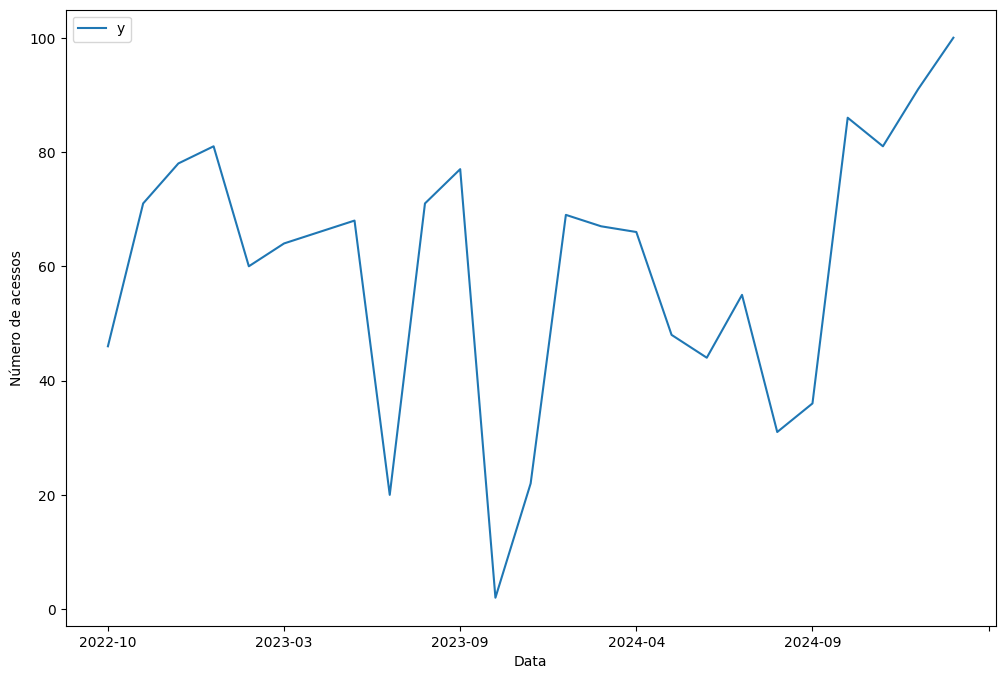

In [134]:
# Uma plotagem simples com MatPlotLib para entendermos como estão distribuídos os dados que já possuímos

ax = df_.set_index('ds').plot(figsize=(12,8))
ax.set_ylabel('Número de acessos')
ax.set_xlabel('Data')


plt.show()

In [144]:
# Instanciando o objeto do Prophet em m

# changepoint_prior_scale define o quão sensível o modelo será a variações dos dados
# por padrão, caso changepoint_prior_scale não seja passado, será de 0.05, mas caso queira ajustar pode aumentar ou diminuir esse número

# Dependendo dos dados do cliente e da forma que estão distribuidos os dados, pode ser necessário alterar esse parâmetro

# um changepoint_prior_scale alto, o tornará mais sensível a mudanças, e quanto mais baixo, o tornará menos sensível
m = Prophet(changepoint_prior_scale=1)
m.fit(df_)

12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:40 - cmdstanpy - INFO - Chain [1] done processing


In [145]:
future = m.make_future_dataframe(periods=10, freq='MS')
future.head()


,ds
0,2022-10-01
1,2022-11-01
2,2022-12-01
3,2023-01-01
4,2023-02-01


In [146]:
forecast = m.predict(future)
forecast[['ds', 'yhat','yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2022-10-01,46.000341,46.000341,46.000341
1,2022-11-01,70.999586,70.999586,70.999586
2,2022-12-01,78.000061,78.000061,78.000061
3,2023-01-01,81.000470,81.000470,81.000470
4,2023-02-01,59.998167,59.998167,59.998167


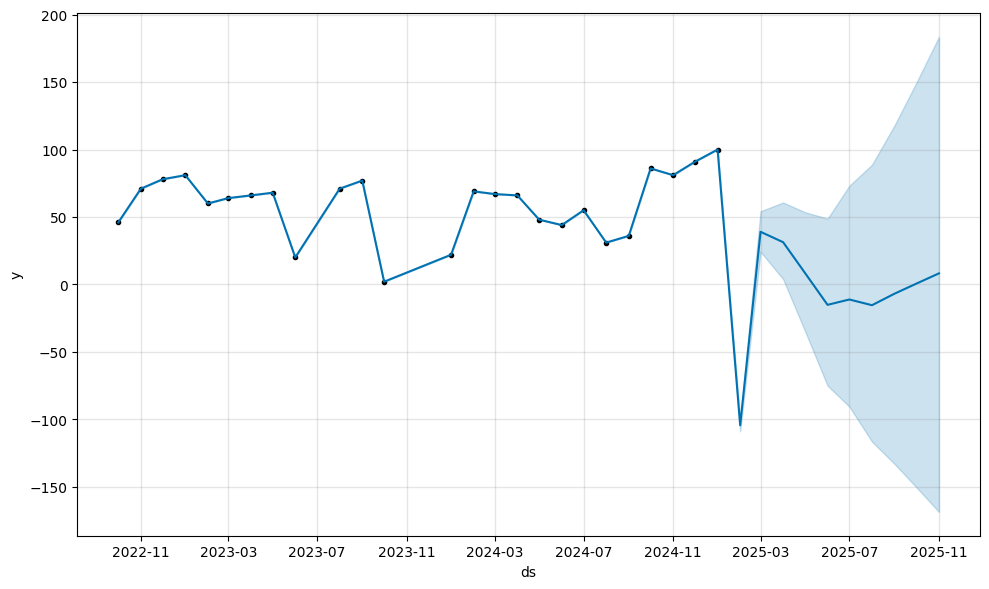

In [147]:
fig1 = m.plot(forecast)

In [107]:
# fig2 = m.plot_components(forecast)

In [148]:
plot_plotly(m, forecast)

In [149]:
plot_components_plotly(m, forecast)


1    2022-11-01
2    2022-12-01
3    2023-01-01
4    2023-02-01
5    2023-03-01
6    2023-04-01
7    2023-05-01
8    2023-06-01
9    2023-08-01
10   2023-09-01
11   2023-10-01
12   2024-01-01
13   2024-02-01
14   2024-03-01
15   2024-04-01
16   2024-05-01
17   2024-06-01
18   2024-07-01
19   2024-08-01
Name: ds, dtype: datetime64[ns]

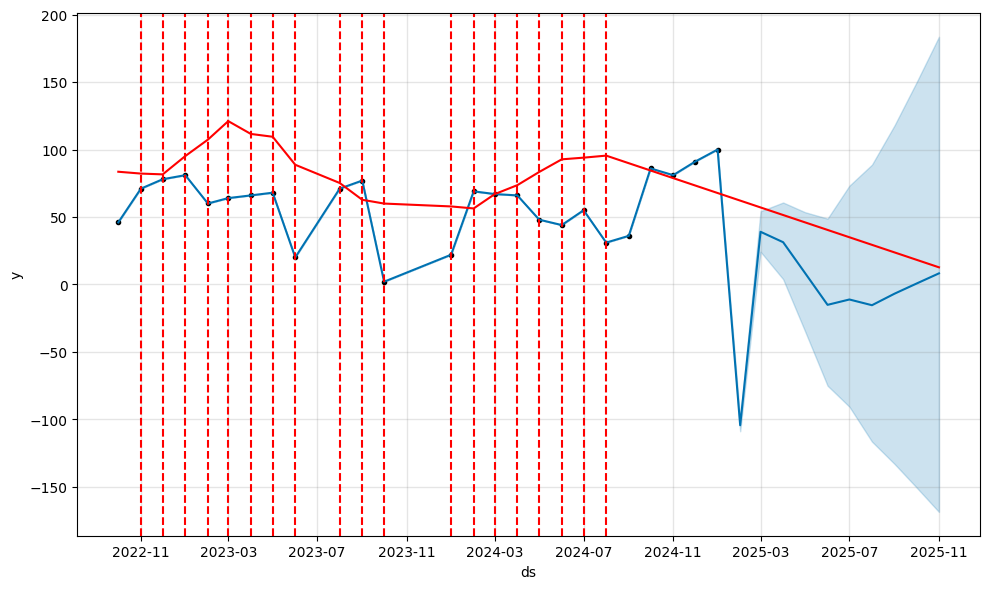

In [150]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
m.changepoints


12:30:23 - cmdstanpy - INFO - Chain [1] start processing
12:30:23 - cmdstanpy - INFO - Chain [1] done processing


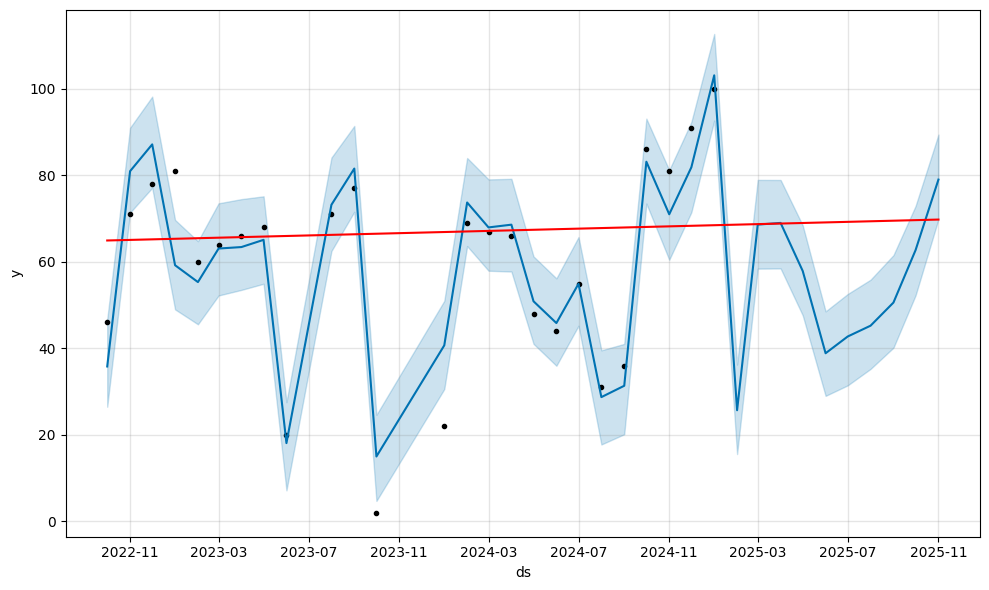

In [151]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(df_).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

11:27:01 - cmdstanpy - INFO - Chain [1] start processing
11:27:01 - cmdstanpy - INFO - Chain [1] done processing


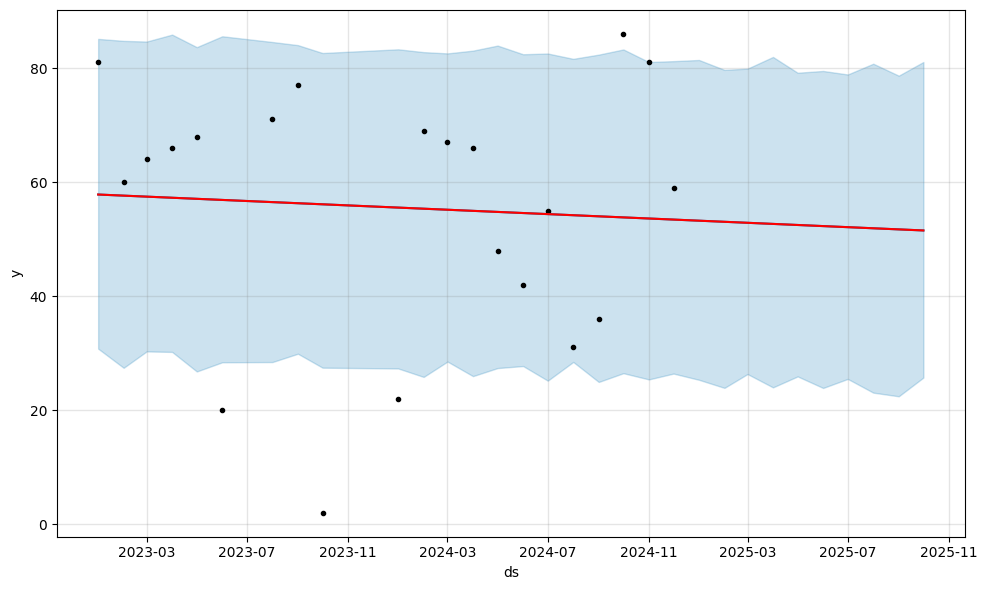

In [112]:
pro_change= Prophet(n_changepoints=24, yearly_seasonality=False)
forecast = pro_change.fit(df_).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

11:27:01 - cmdstanpy - INFO - Chain [1] start processing
11:27:01 - cmdstanpy - INFO - Chain [1] done processing


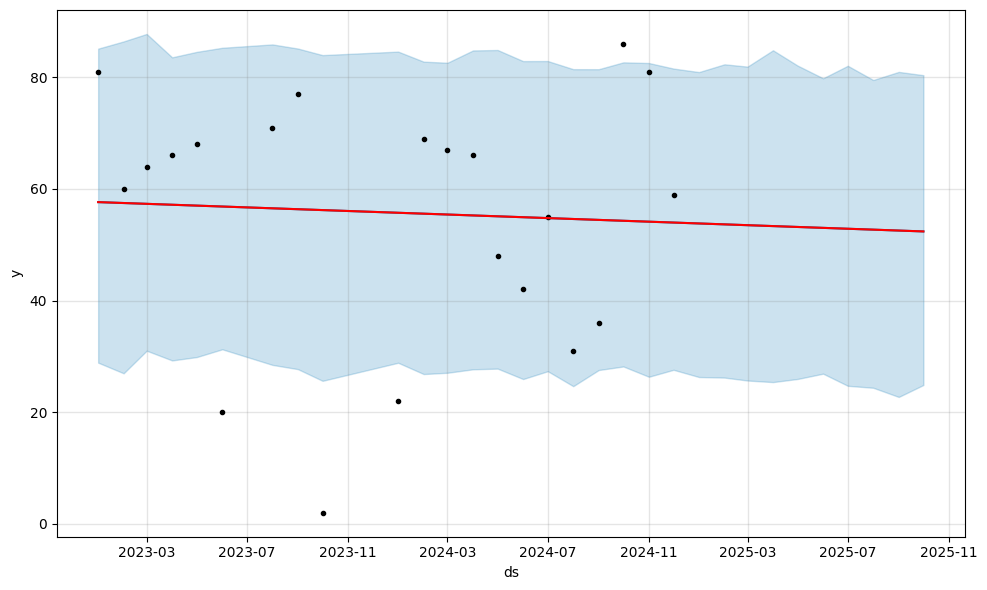

In [113]:
pro_change= Prophet(n_changepoints=10, yearly_seasonality=False, changepoint_prior_scale=0.05)
forecast = pro_change.fit(df_).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [114]:
# pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.5)
# forecast = pro_change.fit(df_).predict(future)
# fig= pro_change.plot(forecast);
# a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)